# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
#import seaborn as sb


In [3]:
import os
cwd=os.getcwd()

workdir=f'{cwd}'
datadir=f'{workdir}/data/'
outdir=f'{workdir}/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise1/data/butane.pdb
C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise1/data/butane.gaff2.xml


In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905595 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,38.58088115614582,235.56798924073112
2000,52.59218979351337,275.78675686655623


In [6]:
os.path.join(workdir, "butane_sim.dcd")

'C:\\Users\\f004q29\\Documents\\School\\PhD\\Fourth Year\\CHEM101_6\\Exercise1\\butane_sim.dcd'

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...


FileExistsError: The file 'C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise1\butane_sim.xtc' already exists.

In [11]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x24341651d30>

In [12]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [13]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x24341653260>

In [14]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


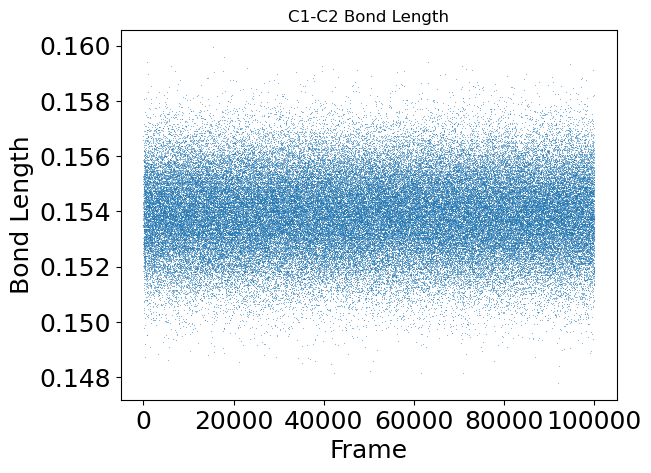

In [15]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=0.1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

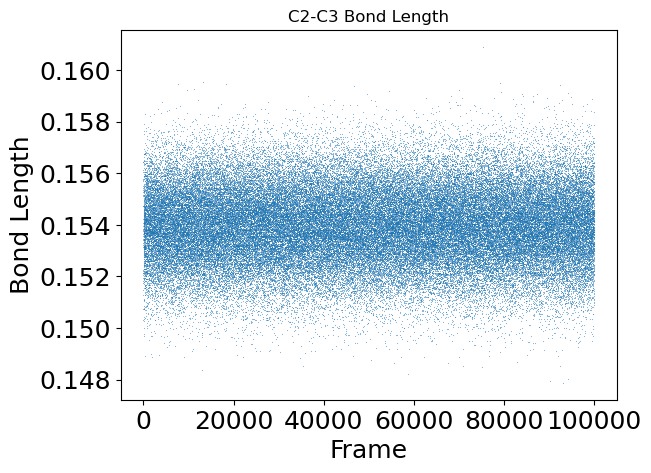

In [16]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

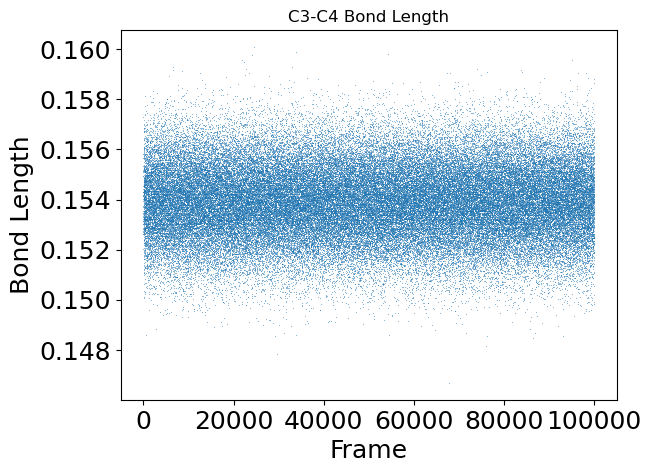

In [17]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

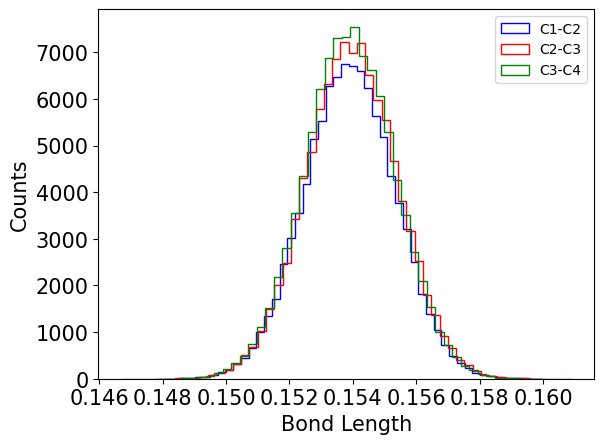

In [18]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

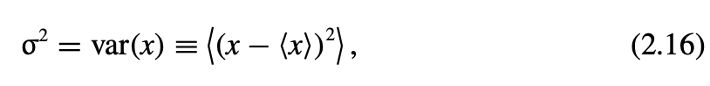

In [19]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [20]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var=np.average((data-ave)**2)
    std=var**0.5
    return var,std
C1C2var,C1C2std=variance(C1C2bondlength)
print("C1C2 variance: ",C1C2var,"C1C2 standard deviation: ",C1C2std)
C2C3var,C2C3std=variance(C2C3bondlength)
print("C2C3 variance: ",C2C3var,"C2C3 standard deviation: ",C2C3std)
C3C4var,C3C4std=variance(C3C4bondlength)
print("C3C4 variance: ",C3C4var,"C3C4 standard deviation: ",C3C4std)

C1C2 variance:  2.0446914e-06 C1C2 standard deviation:  0.001429927070772223
C2C3 variance:  2.0713246e-06 C2C3 standard deviation:  0.0014392097191954331
C3C4 variance:  2.0357197e-06 C3C4 standard deviation:  0.001426786500231058


In [21]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15389815 variance: 2.0446914e-06 std-dev: 0.0014299271
C2-C3 average: 0.15395422 variance: 2.0713246e-06 std-dev: 0.0014392097
C3-C4 average: 0.15390266 variance: 2.0357197e-06 std-dev: 0.0014267865


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


Line Parameters: [0.5001583  0.07697676]


C:\Users\f004q29\AppData\Local\Temp\ipykernel_13364\1769237437.py:9: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


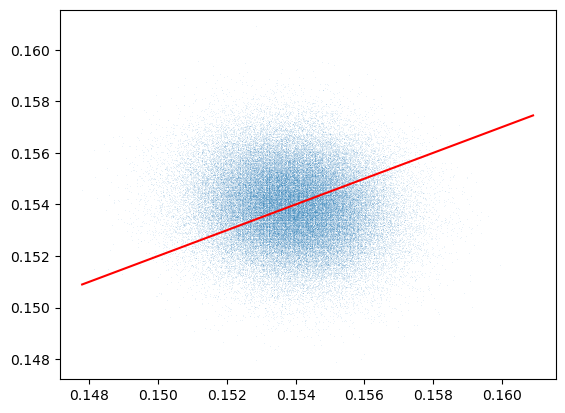

C:\Users\f004q29\AppData\Local\Temp\ipykernel_13364\1769237437.py:22: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


r2: -0.1002374736064852
Line Parameters: [0.49999312 0.07695134]


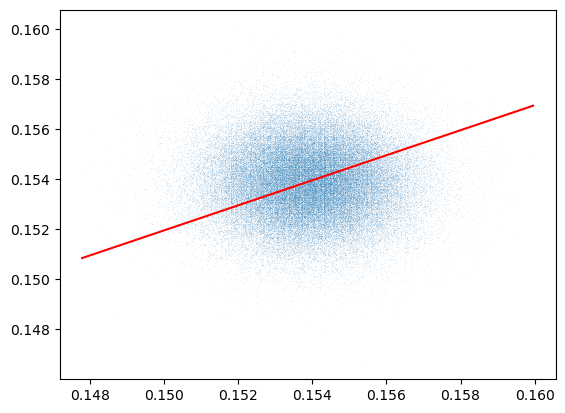

r2: 0.0020242368090294138


In [22]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

This is due to random error in the sampling. If we were to sample the molecule for an infinite amount of time they would approach being indentical since the molecule is symmetric. Since we have sampled for a finite amount of time, random fluctuations have made one pair of bonds appear more correlated than the other pair, but considering error they should be the same.

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

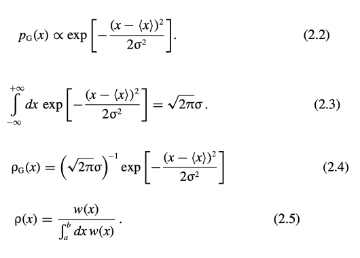
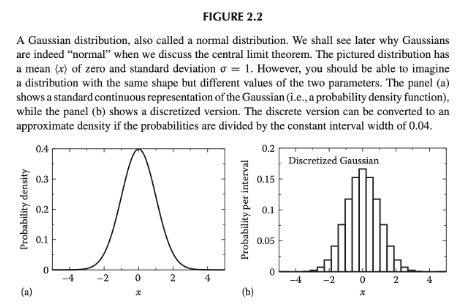

[    0     5    23   108   422  1216  3190  6836 11316 16090 17745 16684
 12498  7745  3836  1545   545   149    42     5] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a:  0.17984237154777738 x_0:  0.15389608231144536 fit_sigma:  -0.0014425075708323052


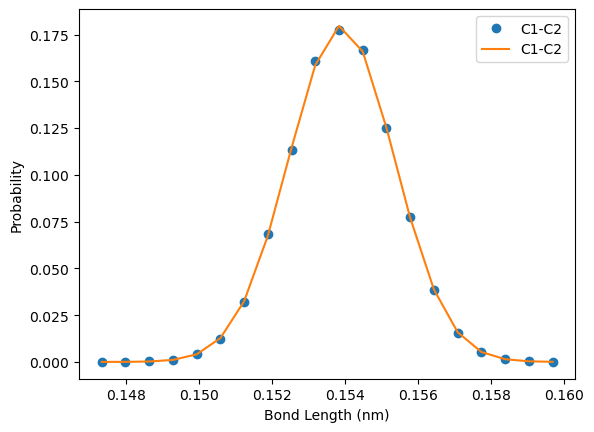

In [23]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a format we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

counts,edges=np.histogram(C1C2bondlength, bins=20, range=[0.147,0.160])
print(counts,edges)

centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))
#First we convert our histogram into bin centers and probabilities
#intead of bin edges and counts:

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

##Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a,x0,sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))
    
#### Now we define a function to fit the gaussian with curve fit
def fit_gauss(x,y):
    parameters,covariance=curve_fit(gauss,x,y)
    fit_a=parameters[0]
    fit_x0=parameters[1]
    fit_sigma=parameters[2]
    print('a: ',fit_a,'x_0: ',fit_x0,'fit_sigma: ',fit_sigma)
    fit_y=gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]

C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o', label='C1-C2')
plt.plot(centers,C1C2_fit,'-', label='C1-C2')
plt.legend()
plt.xlabel('Bond Length (nm)')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


In [24]:
print(edges)
print(edges[:-1])
centers = edges[:-1] + np.diff(edges)/2
print(centers)
density=counts/(np.sum(counts))
print(density)

[0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
[0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935]
[0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ]
[0.0000e+00 5.0000e-05 2.3000e-04 1.0800e-03 4.2200e-03 1.2160e-02
 3.1900e-02 6.8360e-02 1.1316e-01 1.6090e-01 1.7745e-01 1.6684e-01
 1.2498e-01 7.7450e-02 3.8360e-02 1.5450e-02 5.4500e-03 1.4900e-03
 4.2000e-04 5.0000e-05]


***Homework Problem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a:  0.17984237154777738 x_0:  0.15389608231144536 fit_sigma:  -0.0014425075708323052
a:  0.17851021452283436 x_0:  0.15395593828716675 fit_sigma:  -0.00145416842386565
a:  0.1803493680874342 x_0:  0.15390076919726314 fit_sigma:  -0.0014378589121517235


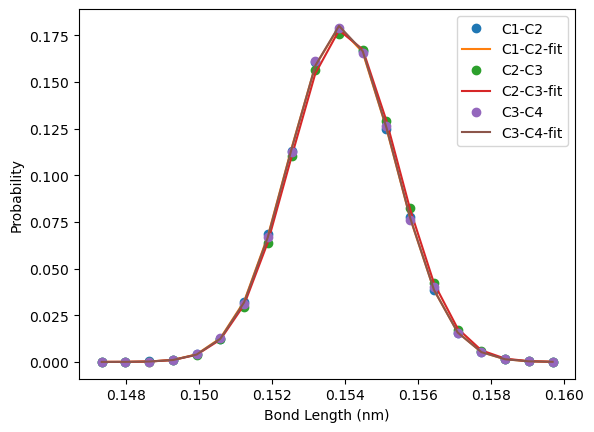

In [25]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
def histogram_bincenters(bondlength_list):
    counts,edges=np.histogram(bondlength_list, bins=20, range=[0.147,0.160])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers,density
#use this function to iterate over all CC bonds, plot the densities and fits

for idx,i in enumerate([C1C2bondlength,C2C3bondlength,C3C4bondlength]):
    centers,density=histogram_bincenters(i)
    fit,fit_params=fit_gauss(centers,density)
    
    plt.plot(centers,density,'o', label=f'C{idx+1}-C{idx+2}')
    plt.plot(centers,fit,'-', label=f'C{idx+1}-C{idx+2}-fit')
plt.legend()
plt.xlabel('Bond Length (nm)')
plt.ylabel('Probability')    
#plt.xlim([0.14,0.16])
plt.show()

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

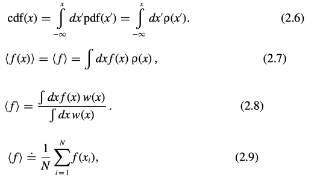

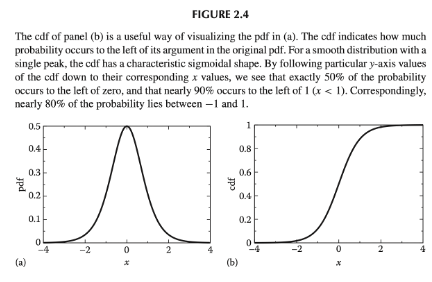

a:  0.17984237154777738 x_0:  0.15389608231144536 fit_sigma:  -0.0014425075708323052
a:  0.17851021452283436 x_0:  0.15395593828716675 fit_sigma:  -0.00145416842386565
a:  0.1803493680874342 x_0:  0.15390076919726314 fit_sigma:  -0.0014378589121517235


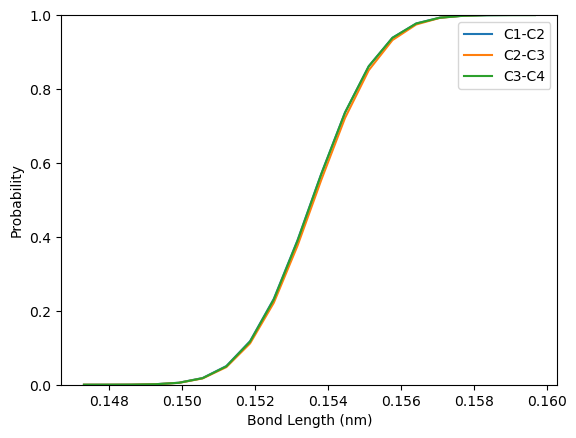

In [26]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####

#hint np.cumsum might be helpful here

#ADD CODE FOR CDFs HERE#
for idx,i in enumerate([C1C2bondlength,C2C3bondlength,C3C4bondlength]):
    fit,fit_params=fit_gauss(histogram_bincenters(i)[0],histogram_bincenters(i)[1])
    
    #plt.plot(centers,np.cumsum(fit),'o', label=f'C{idx+1}-C{idx+2}')
    plt.plot(centers,np.cumsum(fit),'-', label=f'C{idx+1}-C{idx+2}')
plt.legend()
plt.xlabel('Bond Length (nm)')
plt.ylabel('Probability')
plt.ylim([0,1])
plt.show()


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle ***
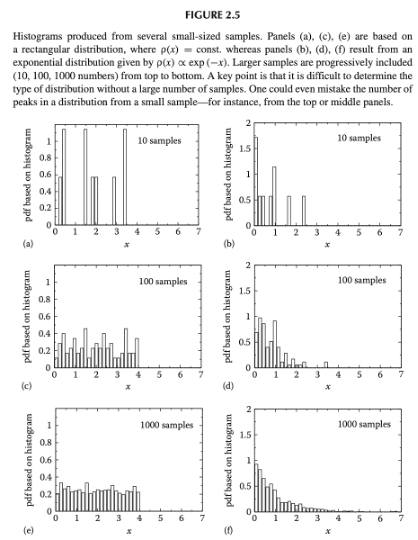

In [27]:
#repeat these here for clarity
##Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a,x0,sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))
    
#### Now we define a function to fit the gaussian with curve fit
def fit_gauss(x,y):
    parameters,covariance=curve_fit(gauss,x,y)
    fit_a=parameters[0]
    fit_x0=parameters[1]
    fit_sigma=parameters[2]
    print('a: ',fit_a,'x_0: ',fit_x0,'fit_sigma: ',fit_sigma)
    fit_y=gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]

a:  19.436430232214228 x_0:  1.9797203608024254 fit_sigma:  0.05227554432245544
a:  17.26125773636837 x_0:  1.9685830007943323 fit_sigma:  0.0587588424932115
a:  16.954379653254225 x_0:  1.9687395432785544 fit_sigma:  -0.05829258604234226
a:  16.7489031357308 x_0:  1.9657508002839974 fit_sigma:  0.059713895498597507


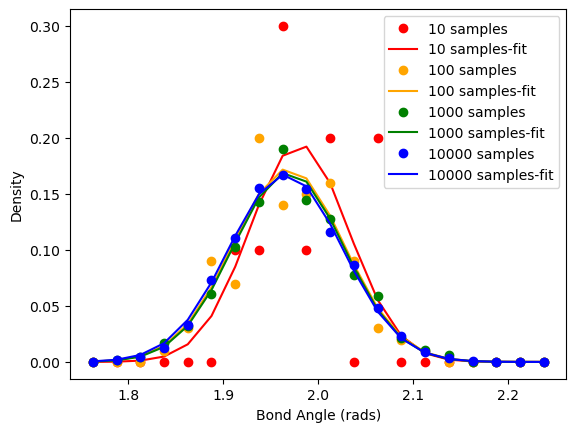

In [28]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO (A guassian?) BOND ANGLE

def histogram_bincenters(bondlength_list):
    counts,edges=np.histogram(bondlength_list, bins=20, range=[1.75,2.25])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers,density

Angle1=[0,4,7]
Angle2=[4,7,10]
ang = md.compute_angles(traj,[Angle1,Angle2])

colors=['red','orange','green','blue']
for idx,i in enumerate(list(range(1,5))):
    ang_sample=np.random.choice(ang[:,0],10**i)
    centers,density=histogram_bincenters(ang_sample)
    fit,fit_params=fit_gauss(centers,density*100) #for some reason the fitting fails without this factor of 100, maybe values are too small?
    plt.plot(centers,density,'o', label=f'{10**i} samples',c=colors[idx])
    plt.plot(centers,fit/100,'-', label=f'{10**i} samples-fit',c=colors[idx])

#plt.ylim([-20,0.2])
plt.legend()
plt.xlabel('Bond Angle (rads)')
plt.ylabel('Density')
plt.show()


a:  1382.5479983954992 x_0:  491.0216654656448 fit_sigma:  135.76739766153807
a:  24.368411588035016 x_0:  -1.4315018796606687 fit_sigma:  0.14159743831816143
a:  21.88021699348101 x_0:  -1.4276802209380262 fit_sigma:  0.14539119103277987
a:  23.586508187252115 x_0:  -1.430792190862784 fit_sigma:  0.13093927682451256


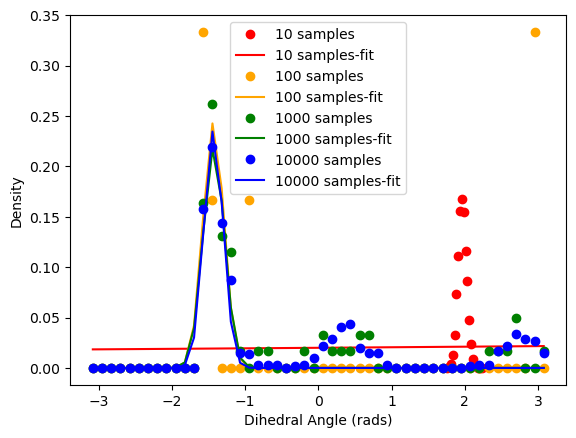

In [29]:
#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?
# The data is not unimodal
def histogram_bincenters(bondlength_list):
    counts,edges=np.histogram(bondlength_list, bins=50, range=[-np.pi,np.pi])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers,density

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
CCCC_dihe=CCCC_torsion[:,0]
CCCC_dihe+=np.pi/2
#CCCC_dihe=np.abs(CCCC_dihe)


for idx,i in enumerate(list(range(1,5))):
    ang_sample=np.random.choice(CCCC_dihe,10**i)
    plt.plot(centers,density,'o', label=f'{10**i} samples',c=colors[idx])
    try:
        centers,density=histogram_bincenters(ang_sample)
        fit,fit_params=fit_gauss(centers,density*100) #for some reason the fitting fails without this factor of 100, maybe values are too small?
        plt.plot(centers,fit/100,'-', label=f'{10**i} samples-fit',c=colors[idx])
    except:
        #often the 10 samples trial is too small to fit, so just skip it
        1==1

#plt.ylim([-20,0.2])
plt.legend()
plt.xlabel('Dihedral Angle (rads)')
plt.ylabel('Density')
plt.show()

In [30]:
np.min(CCCC_dihe)

-1.5707961

In [31]:
C1C2bondlength[:,0]

array([0.15674505, 0.15290847, 0.1539253 , ..., 0.15547991, 0.15176627,
       0.1570223 ], dtype=float32)

In [32]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[2.00474   1.9172626]
 [1.9949735 1.9160615]
 [2.00674   1.8995883]
 ...
 [1.8705969 1.8967375]
 [1.9618956 1.9906015]
 [1.91056   1.947193 ]]


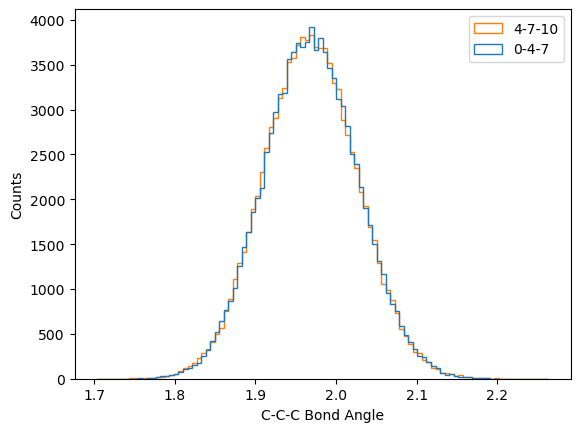

[[ 2.8792331]
 [-2.6699336]
 [ 2.9107673]
 ...
 [-3.1354923]
 [-3.114563 ]
 [ 3.067893 ]]
[[ 164.9679 ]
 [-152.97592]
 [ 166.77467]
 ...
 [-179.65047]
 [-178.45131]
 [ 175.77731]]


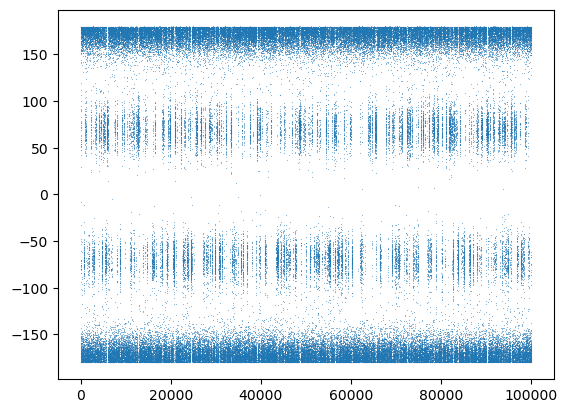

In [33]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
#ang1
ang2=ang[:,1]
#ang1
#plt.scatter(ang1,marker='o',s=0.1)
#plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))
plt.plot((np.rad2deg(CCCC_torsion)),linewidth=0,marker='x',markersize=.1)

(0.0, 1000.0)

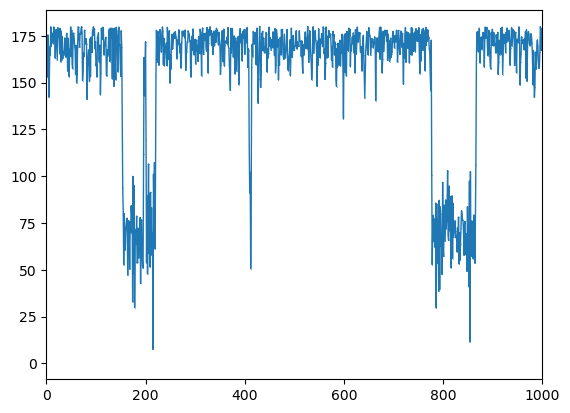

In [34]:
#np.where(CCCC_torsion<=0)
#CCCC_tor_offset=np.rad2deg(CCCC_torsion)
#for i in range(len(CCCC_tor_offset)):
#    if(CCCC_tor_offset[i]<0):
#        CCCC_tor_offset+=360
plt.plot(np.abs((np.rad2deg(CCCC_torsion))),linewidth=1,marker='x',markersize=.1)
plt.xlim([0,1000])

In [35]:
CCCC_dihe

array([ 4.4500294, -1.0991372,  4.4815636, ..., -1.564696 , -1.5437666,
        4.6386895], dtype=float32)

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [36]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### This will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html

#no it wont
import pandas as pd

CCCC_dihe=CCCC_torsion[:,0]
df=pd.DataFrame(CCCC_dihe.copy())
df[0]*=180/np.pi

answer=len(df.loc[(df[0]<0) &(df[0]>-125)])/len(df)
print(f'There is a {round(answer,3)*100}% chance of finding the system in the higher energy rotamer with dihedral angle betweeon 0 and -125 degrees')
answer=len(df.loc[(df[0]<125) &(df[0]>0)])/len(df)
print(f'There is a {round(answer,3)*100}% chance of finding the system in the higher energy rotamer with dihedral angle betweeon 0 and 125 degrees')


There is a 10.8% chance of finding the system in the higher energy rotamer with dihedral angle betweeon 0 and -125 degrees
There is a 11.4% chance of finding the system in the higher energy rotamer with dihedral angle betweeon 0 and 125 degrees


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r^2: 0.006724454882655981


<function matplotlib.pyplot.show(close=None, block=None)>

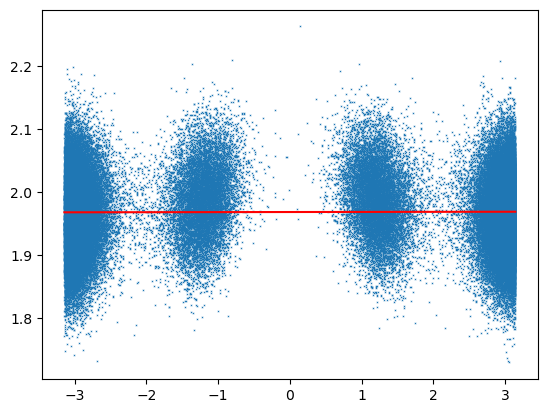

In [37]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
CCCC_dihe=CCCC_torsion[:,0]
plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print('r^2:',r[0,1])

line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y=line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show
##### ADD FANCY SEABORN PLOT HERE ######
#sns.jointplot(x=CCCC_dihe,y=ang1,kind=

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

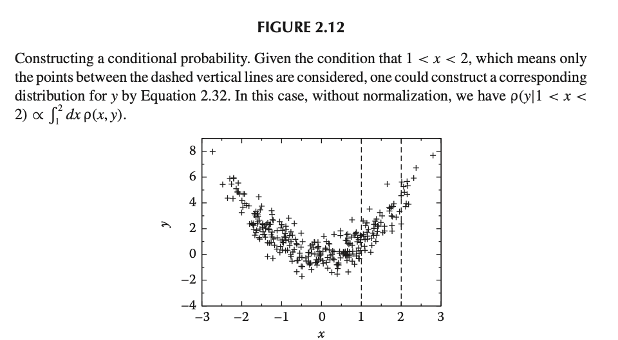

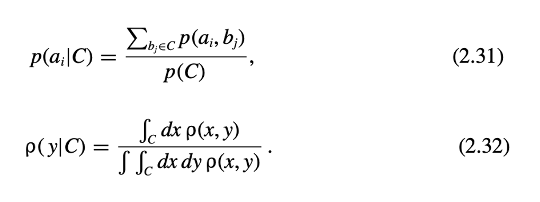

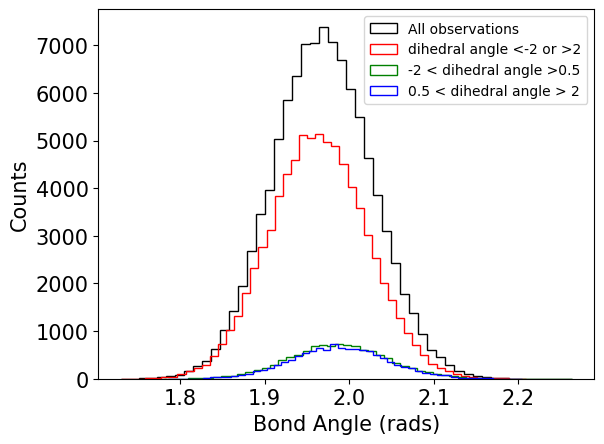

The average bond angle for all observations is                   1.969 rads
The average bond angle for dihedral angles <-2 or >2 is          1.963 rads
The average bond angle for dihedral angles between -2 and 0.5 is 1.987 rads
The average bond angle for dihedral angles between 0.5 and 2 is  1.988 rads
By creating groups of bond angles based on dihedral angle, we can see that the average bond angle is slightly higher for the higher energy dihedral angles. Each of the groups are more gaussian and the varying centers account for the tail seen in the histogram for all observations


In [38]:
#Homework problem 3 Solution ##
angles=pd.DataFrame(CCCC_dihe.copy(),columns=['dihedral_angle'])
angles['bond_angle']=ang1.copy()
angles

plt.hist(angles['bond_angle'],label='All observations',color='black',histtype='step',bins=50)

group1=angles.loc[(angles['dihedral_angle']<-2)| (angles['dihedral_angle']>2)]
plt.hist(group1['bond_angle'],label='dihedral angle <-2 or >2',color='red',histtype='step',bins=50)

group2=angles.loc[(angles['dihedral_angle']>-2) & (angles['dihedral_angle']<0.5)]
plt.hist(group2['bond_angle'],label='-2 < dihedral angle >0.5',color='green',histtype='step',bins=50)
      
group3=angles.loc[(angles['dihedral_angle']>0.5) & (angles['dihedral_angle']<2)]
plt.hist(group3['bond_angle'],label='0.5 < dihedral angle > 2',color='blue',histtype='step',bins=50)
      
plt.legend(loc='upper right')
plt.xlabel('Bond Angle (rads)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
print(f'The average bond angle for all observations is                   {np.mean(angles['bond_angle']):.3f} rads')
print(f'The average bond angle for dihedral angles <-2 or >2 is          {np.mean(group1['bond_angle']):.3f} rads')
print(f'The average bond angle for dihedral angles between -2 and 0.5 is {np.mean(group2['bond_angle']):.3f} rads')
print(f'The average bond angle for dihedral angles between 0.5 and 2 is  {np.mean(group3['bond_angle']):.3f} rads')
print('By creating groups of bond angles based on dihedral angle, we can see that the average bond angle is slightly higher for the higher energy dihedral angles. Each of the groups are more gaussian and the varying centers account for the tail seen in the histogram for all observations')

In [39]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[2.00474   1.9949735 2.00674   ... 1.8705969 1.9618956 1.91056  ]
[1.9949735 2.00674   2.0562158 ... 1.8705969 1.9618956 1.91056  ]
[2.00474   1.9949735 2.00674   ... 1.9559449 1.8705969 1.9618956]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


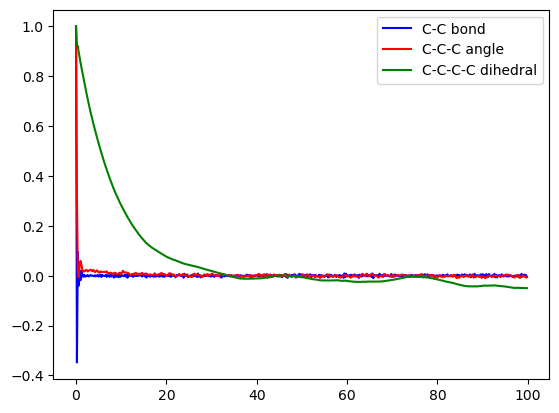

In [40]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

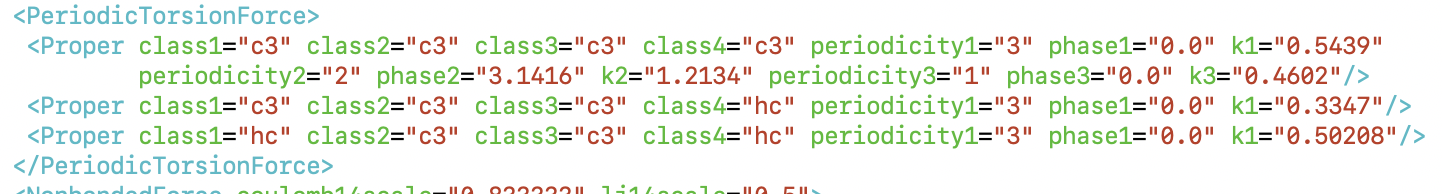

In [41]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


In [42]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [43]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsions=md.compute_dihedrals(traj, [CCCC_index])


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


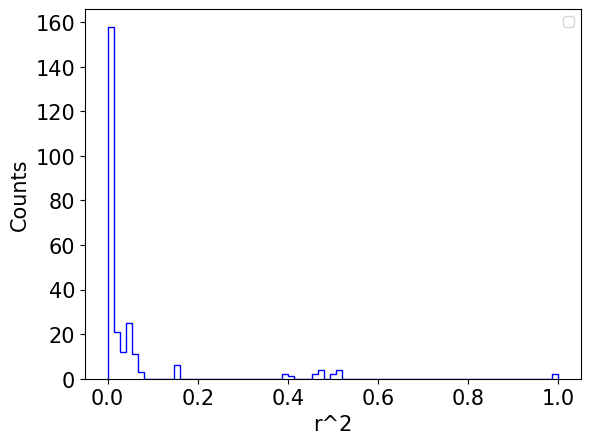

In [44]:
# find the most and least correlated
from itertools import combinations,permutations
from scipy.stats import linregress

HCCH_torsions=pd.DataFrame(HCCH_torsions)
CCCH_torsions=pd.DataFrame(CCCH_torsions)
CCCC_torsions=pd.DataFrame(CCCC_torsions)

all_torsions=pd.DataFrame()
for i in range(len(HCCH_torsions.columns)):
    all_torsions[f'HCCH_{i}']=HCCH_torsions[i]
for i in range(len(CCCH_torsions.columns)):
    all_torsions[f'CCCH_{i}']=CCCH_torsions[i]
for i in range(len(CCCC_torsions.columns)):
    all_torsions[f'CCCC_{i}']=CCCC_torsions[i]

correlations=[linregress(all_torsions[i[0]],all_torsions[i[1]])[2]**2 for i in combinations(all_torsions.columns,2)]


plt.hist(correlations,color='blue',histtype='step',bins=75)      
plt.legend(loc='upper right')
plt.xlabel('r^2', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

C:\Users\f004q29\AppData\Local\Temp\ipykernel_13364\1003897810.py:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for i in nlargest(5,pd.unique(correlations)):


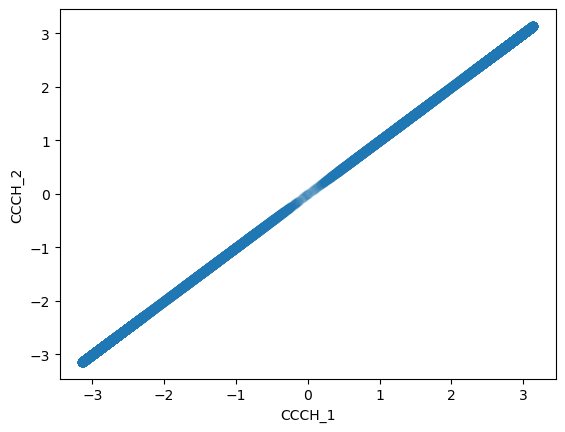

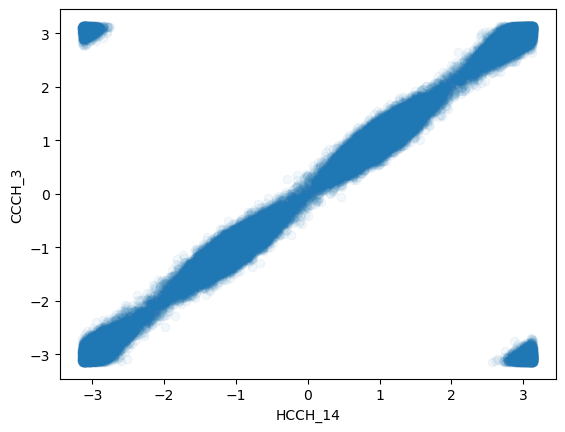

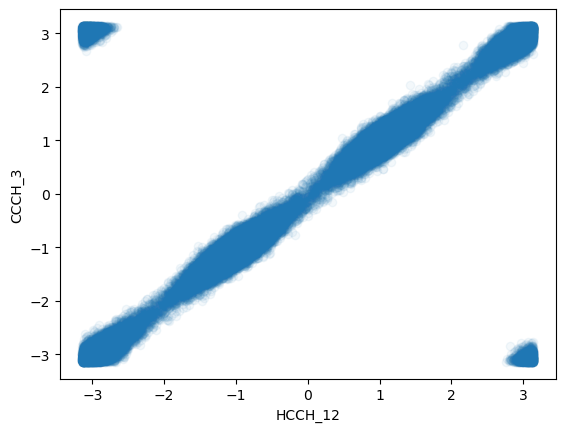

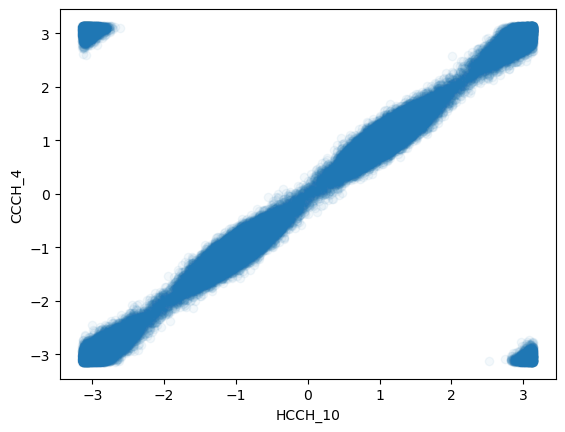

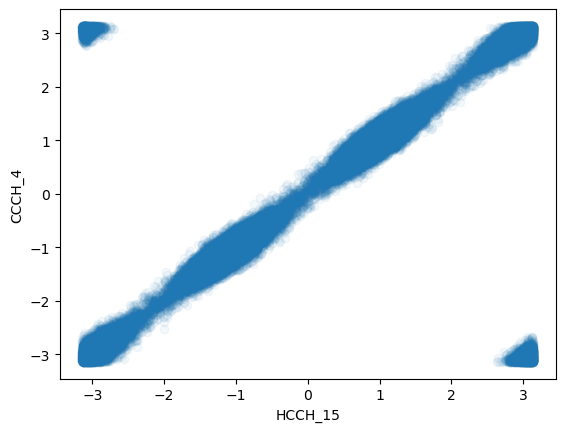

In [45]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT YOU SEE
#Consider CCCC vs. [8,7,4,5]

from heapq import nlargest,nsmallest

combos=[i for i in combinations(all_torsions.columns,2)]
for i in nlargest(5,pd.unique(correlations)):
    plt.scatter(all_torsions[combos[correlations.index(i)][0]],all_torsions[combos[correlations.index(i)][1]],alpha=0.05)
    plt.xlabel(combos[correlations.index(i)][0])
    plt.ylabel(combos[correlations.index(i)][1])
    plt.show()

There are some angles that are always nearly equal. For the first plot, these are along the same section of carbon backbone, just different hydrogens. Their bond angle must not be changing and so the dihedral angle stays the same since as the terminal carbon moves the hydrogens move with it.
The others plots have some more variability but still represent the angles being essentially the same. The extra 'blobs' in the corner of the plot can be translated to still be on the line since they are just rotations slightly more than +/- 360deg. These again follow similar sections along butane's backbone so it makes sense that there is a lot of similarity between the dihedral angles.

C:\Users\f004q29\AppData\Local\Temp\ipykernel_13364\1005126640.py:4: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for i in nsmallest(5,pd.unique(correlations)):


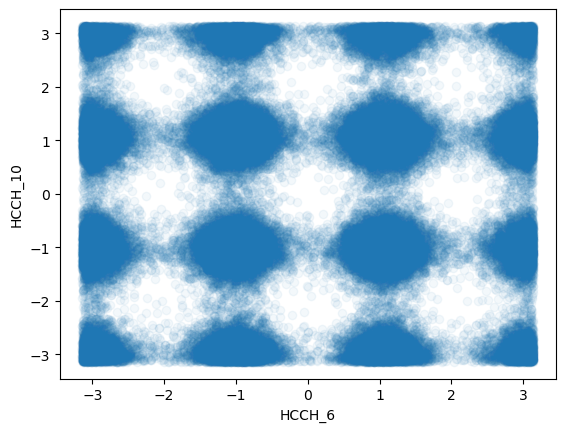

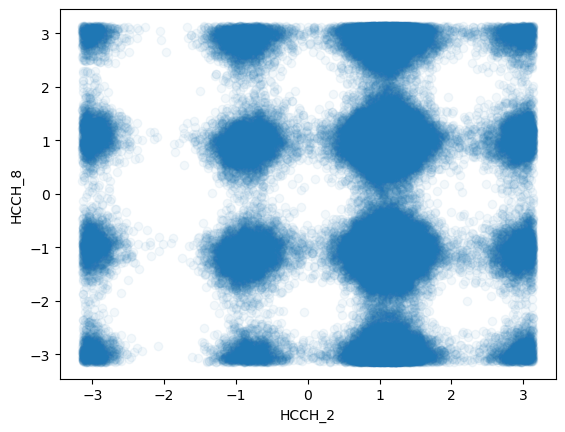

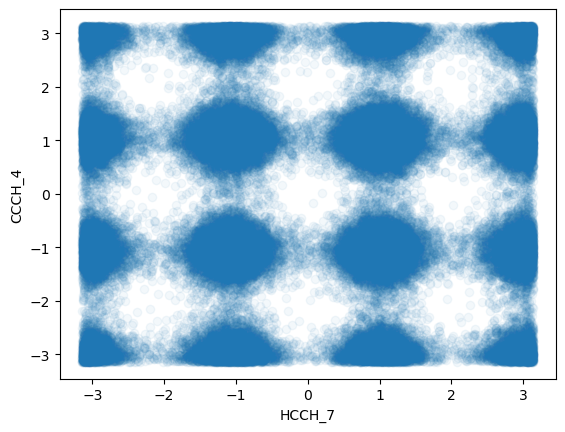

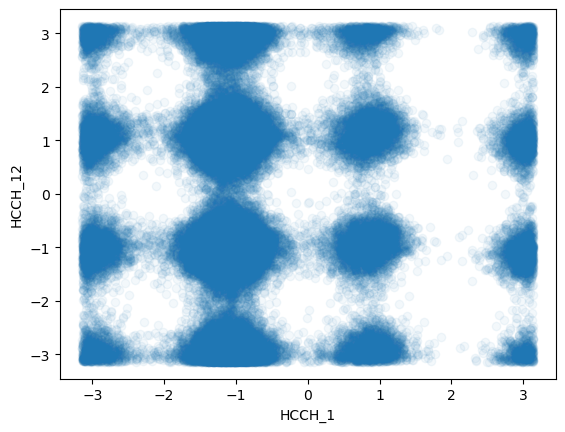

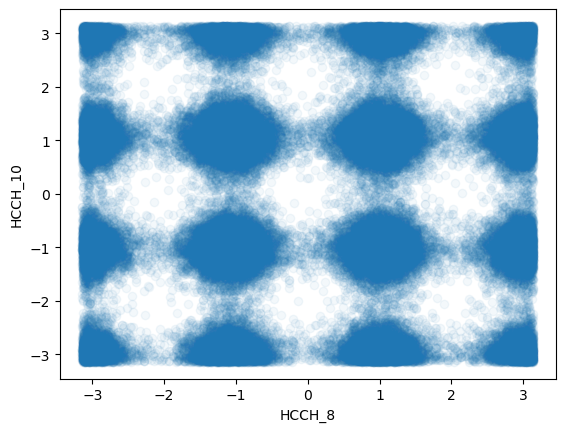

In [46]:
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]

for i in nsmallest(5,pd.unique(correlations)):
    plt.scatter(all_torsions[combos[correlations.index(i)][0]],all_torsions[combos[correlations.index(i)][1]],alpha=0.05)
    plt.xlabel(combos[correlations.index(i)][0])
    plt.ylabel(combos[correlations.index(i)][1])
    plt.show()

There are some dihedral angles that seem to have very little relationship to eachother, except for the fact that they avoid specfic combinations of dihedral angles. These pairs of dihedral angles involve different sections along the carbon backbone. The regions they avoid may be where the atoms sticking off the carbon backbone are aligned so they are close to eachother and thus would repel.

In [47]:
all_torsions

HCCH_0    HCCH_1    HCCH_2    HCCH_3    HCCH_4    HCCH_5    HCCH_6  \
0      2.882310 -1.449473  0.833621  2.785024  1.139762 -0.805171 -2.911904   
1     -2.717791 -0.719919  1.457870 -2.827444  1.206427 -0.990446 -2.998364   
2      2.971624 -1.367744  0.845273  2.789091  0.322510 -1.683775  2.465499   
3      3.011536 -1.226273  0.960381  3.005757  0.656527 -1.476689  2.908233   
4     -3.030293 -0.935737  1.305714 -2.882915  1.225566 -0.859779 -2.980638   
...         ...       ...       ...       ...       ...       ...       ...   
99995  2.520732 -1.799301  0.412947  2.376099 -1.191922  3.077552  1.145658   
99996  3.048614 -1.226190  1.094761  3.103142 -0.890711 -2.924750  1.220495   
99997 -3.038222 -0.830159  1.186312 -2.888811 -1.117784  3.102353  0.890216   
99998  3.068240 -1.145646  0.978479  3.047779 -1.421301  2.906741  0.738845   
99999  2.975621 -1.120346  0.981452 -3.114514 -1.327470  2.917927  0.860385   

         HCCH_7    HCCH_8    HCCH_9  ...   HCCH_13   HCCH_14   HCCH_15  \
0     -3.115265  1.222987 -0.883746  ... -1.048037  1.089526  3.087980   
1     -3.092780  0.993532 -1.014385  ... -1.391241  0.674416  2.772041   
2      2.266493  0.260209 -1.873703  ... -1.693639  0.463106  2.594907   
3      2.751145  0.617929 -1.280334  ... -1.215930  1.119989  3.090460   
4     -3.117652  1.080189 -1.040671  ... -1.019910  1.130957 -3.091872   
...         ...       ...       ...  ...       ...       ...       ...   
99995  0.801293 -1.212418  3.138873  ... -3.060875 -1.121859  1.015699   
99996  1.068106 -0.965933 -3.103873  ... -2.694319 -0.791043  1.115782   
99997  0.908506 -1.154543  2.916506  ...  3.130057 -1.261952  0.938597   
99998  0.612250 -1.342892  2.772397  ...  2.976055 -1.255383  0.855184   
99999  0.804665 -1.233124  2.992520  ...  2.689023 -1.309820  0.754172   

         CCCH_0    CCCH_1    CCCH_2    CCCH_3    CCCH_4    CCCH_5    CCCC_0  
0      2.486644  2.706153  2.706153  1.047843 -3.097780  1.047843  2.879233  
1     -3.084558 -2.521863 -2.521863  0.759852  2.825508  0.759852 -2.669934  
2      2.344063 -2.949249 -2.949249  0.520982  2.677727  0.520982  2.910767  
3      2.555526 -2.827649 -2.827649  0.952894 -2.994373  0.952894  3.063385  
4      2.891405  3.129771  3.129771  1.170958 -2.961361  1.170958 -3.029180  
...         ...       ...       ...       ...       ...       ...       ...  
99995  2.446191  2.811007  2.811007 -0.873905  1.065111 -0.873905  2.361865  
99996 -3.043137 -2.534396 -2.534396 -0.607541  1.295736 -0.607541 -3.007388  
99997  3.126941 -2.696351 -2.696351 -1.074265  0.816911 -1.074265 -3.135492  
99998 -2.768504 -2.816018 -2.816018 -1.298507  0.753240 -1.298507 -3.114563  
99999 -2.994836 -2.872355 -2.872355 -1.430149  0.854193 -1.430149  3.067893  

[100000 rows x 23 columns]

**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

In [48]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT


C:\Users\f004q29\AppData\Local\Temp\ipykernel_13364\2035528177.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for i in nsmallest(20,pd.unique(diffs)):


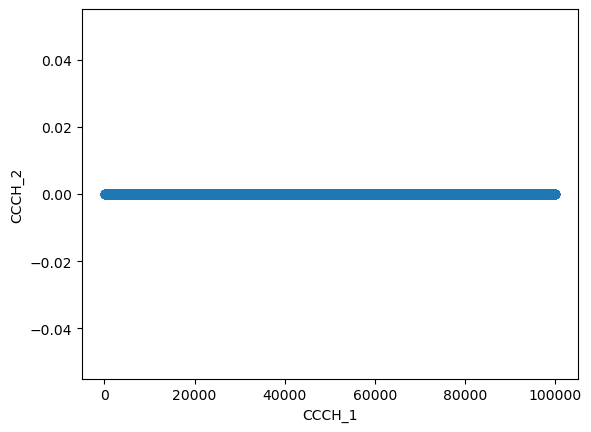

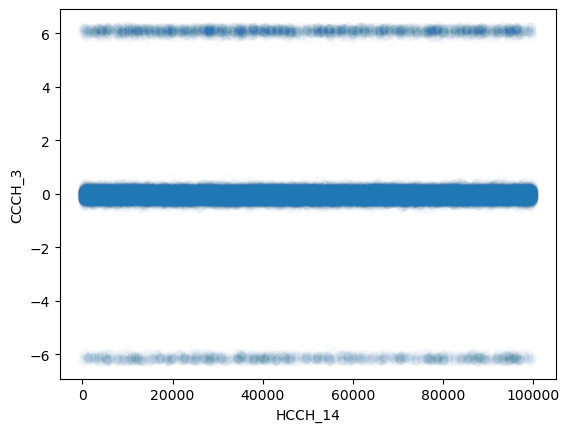

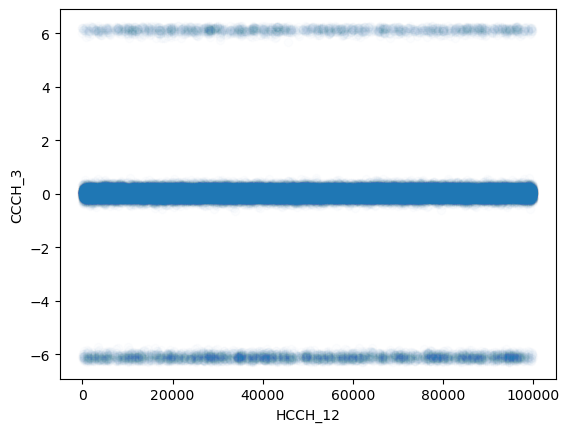

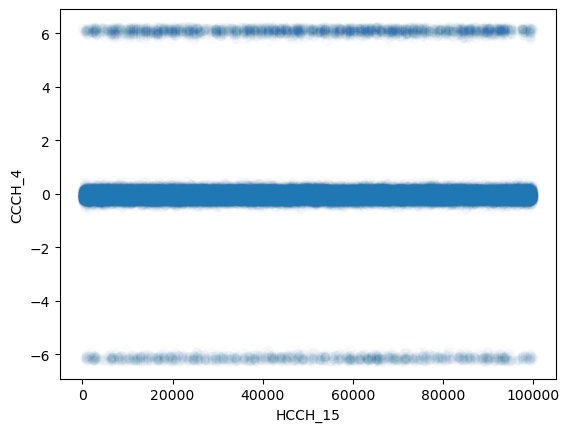

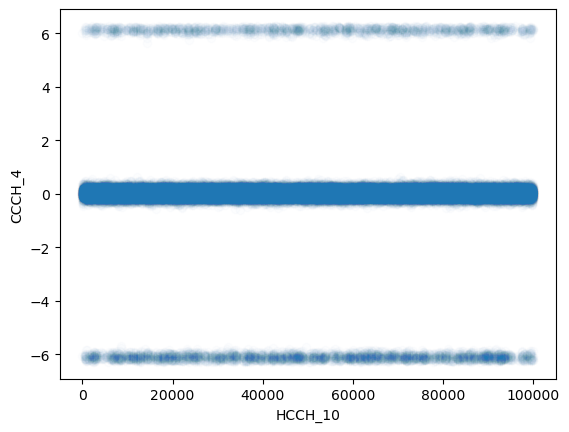

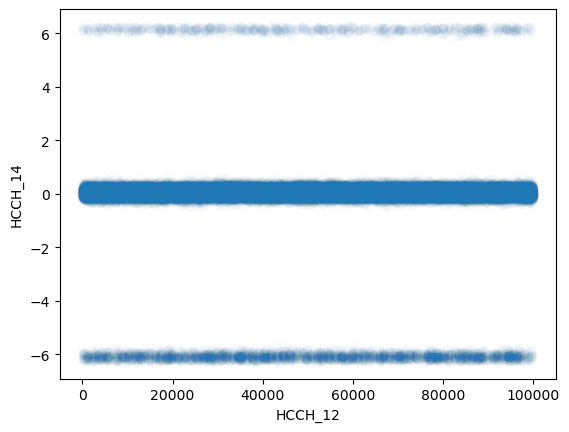

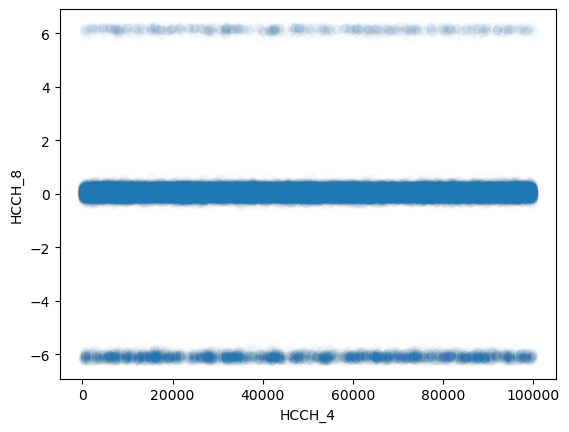

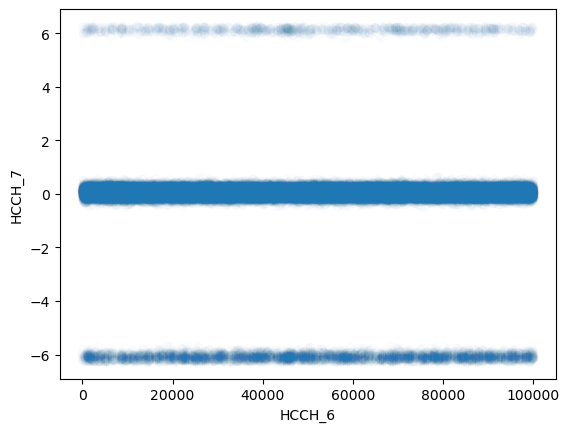

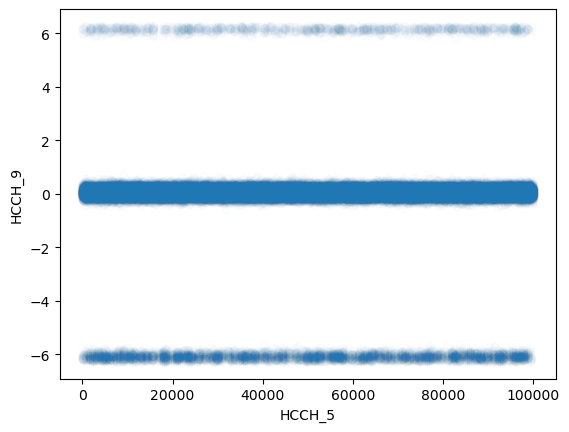

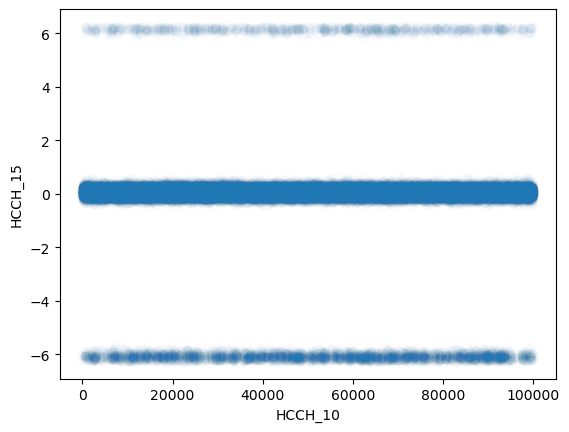

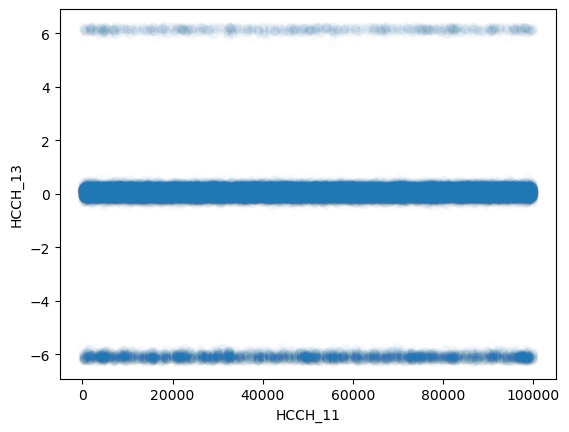

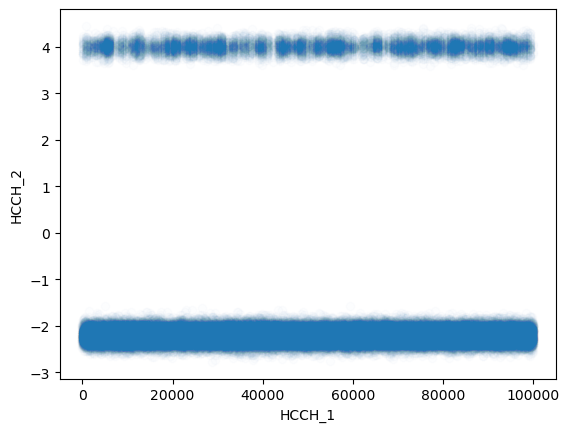

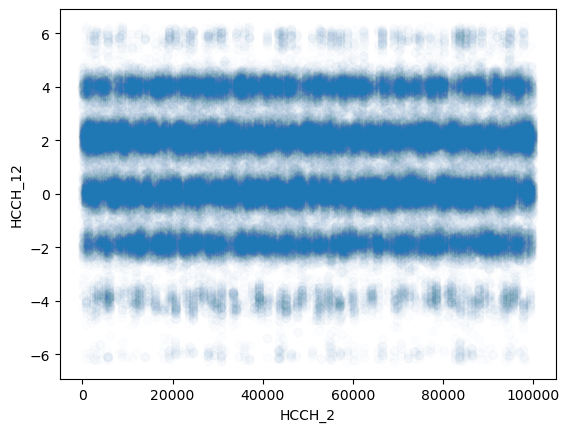

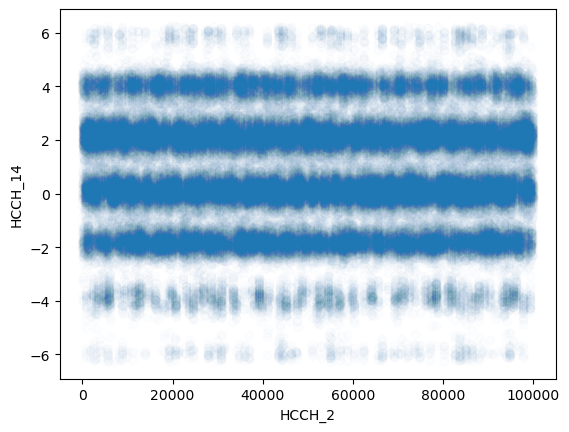

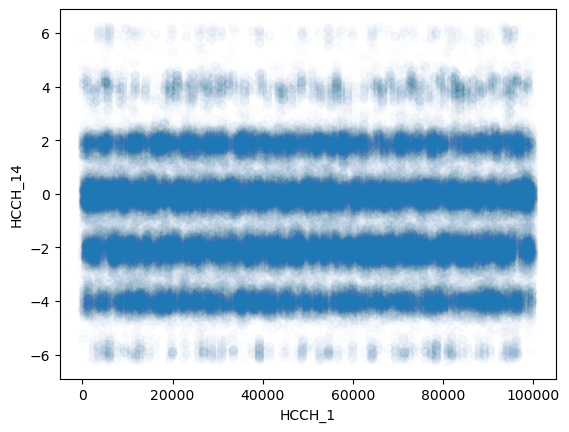

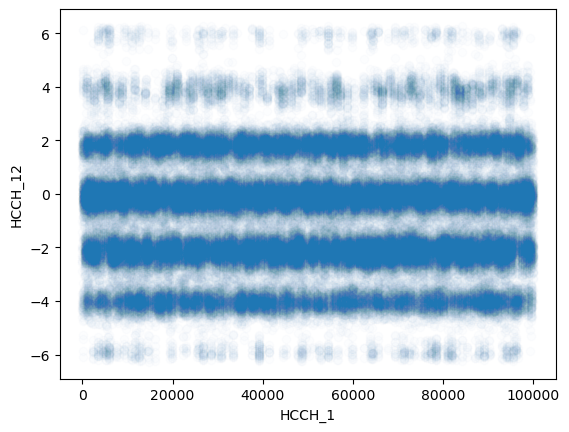

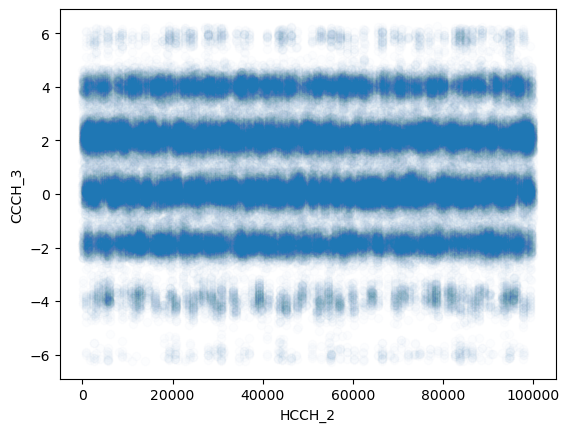

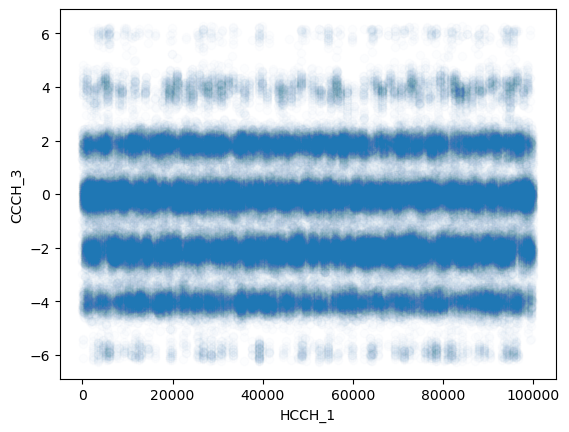

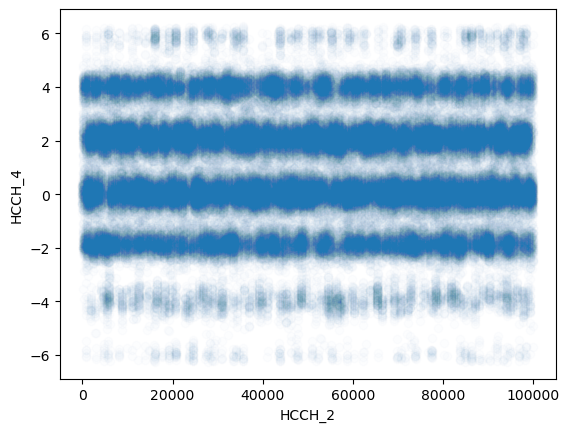

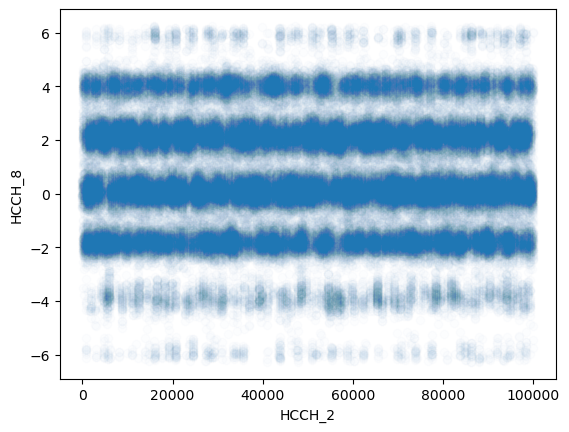

In [49]:
diffs=[np.std(all_torsions[i[0]]-all_torsions[i[1]]) for i in combinations(all_torsions.columns,2)]
for i in nsmallest(20,pd.unique(diffs)):
    plt.scatter(list(range(len(all_torsions))),all_torsions[combos[diffs.index(i)][0]]-all_torsions[combos[diffs.index(i)][1]],alpha=0.01)
    plt.xlabel(combos[diffs.index(i)][0])
    plt.ylabel(combos[diffs.index(i)][1])
    plt.show()

(I know the prompt said to pick only two, but some of the later plots are cool looking)

Torsions that are highly correlated also have a systematic offset. This is because they are along similar sections of the carbon backbone and the bond angles between the atoms that make these sections seperate do not change much.

In [50]:
####WEEK 1 STOP HERE######

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

###SOLUTION#####
I fit to it by hand, guessing a bunch of terms, eventaully I arrived to the following correction, added on top of the existing torsion potential:
(1-cos(2x-2)+(1-cos(4x-4))+(1-cos(6x-6))+(1-cos(8x-8)


***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [74]:
#RUN NEW MD SIMULATION HERE#

#copied from above
cwd=os.getcwd()

workdir=f'{cwd}'
datadir=f'{workdir}/data/'
outdir=f'{workdir}/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2cor1.xml'
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise1/data/butane.pdb
C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise1/data/butane.gaff2cor1.xml


In [75]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 9.833288963997568 kJ/mol
Potential energy after minimization is 8.352033247737156 kJ/mol


In [76]:
print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,37.017196830283936,274.76545445756295
2000,30.28162599432804,260.61441597905355


In [77]:
import time
print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim_corr.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,48.55463145557534,282.9356526449456,--
500000,999.9999999901769,33.88462232541804,267.0854999748571,1.32e+04
750000,1499.9999999783536,58.69402084934909,241.04659803668164,1.34e+04
1000000,1999.9999999665301,33.12572885751547,291.39405779467387,1.36e+04
1250000,2499.9999999547067,47.101951896583635,244.30600951933957,1.37e+04
1500000,2999.9999999428833,82.0973456085876,280.8209679338962,1.38e+04
1750000,3499.99999993106,52.008862941311065,186.1766122470922,1.38e+04
2000000,3999.9999999192364,37.477276136814076,224.35866495079432,1.37e+04
2250000,4499.9999999992715,49.09956768872685,209.75596305684493,1.38e+04
2500000,5000.000000101135,52.78204580253771,286.3568125789221,1.38e+04
2750000,5500.000000202998,67.81541688598192,518.8197744466053,1.38e+04
3000000,6000.000000304862,51.80488470260295,244.5891898837078,1.39e+04
3250000,6500.000000406725,59.3691300378

In [78]:
traj = md.load(os.path.join(workdir, "butane_sim_corr.xtc"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x2434336e690>

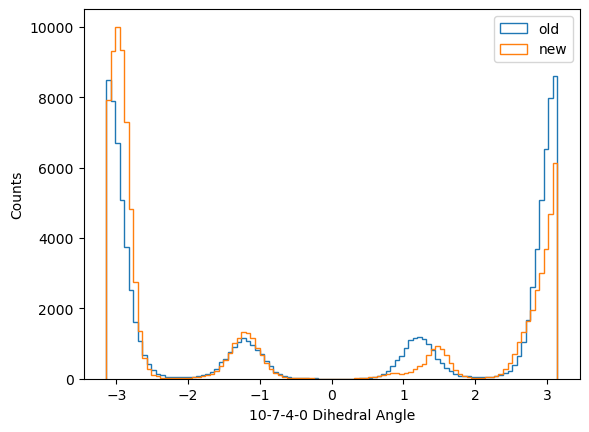

In [79]:
#Compare New Dihedral Distribution HERE)

CCCC_index=[10,7,4,0]
CCCC_torsion_new=md.compute_dihedrals(traj, [CCCC_index])
#plt.plot((np.rad2deg(CCCC_torsion)),linewidth=0,marker='x',markersize=.1)
plt.hist(CCCC_torsion[:,0],bins=100,histtype='step',label='old')
plt.hist(CCCC_torsion_new[:,0],bins=100,histtype='step',label='new')
plt.legend()
plt.xlabel(f'{"-".join([str(i) for i in CCCC_index])} Dihedral Angle')
plt.ylabel('Counts')
plt.show()

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


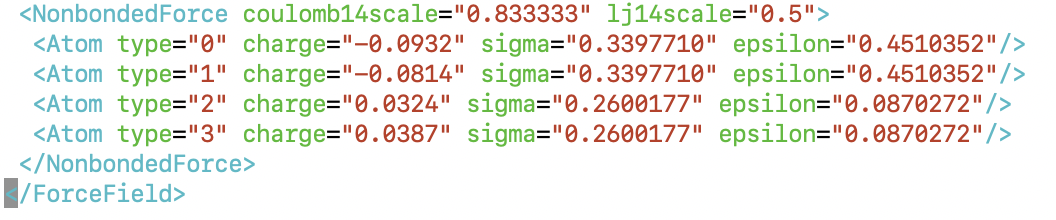




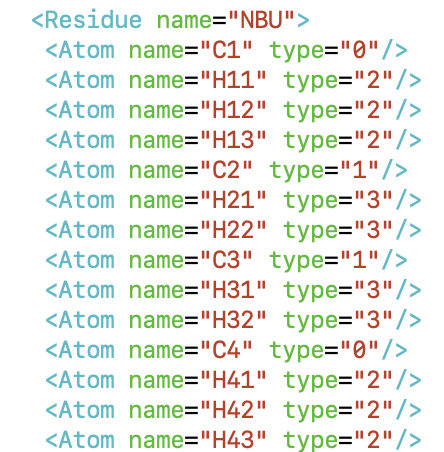

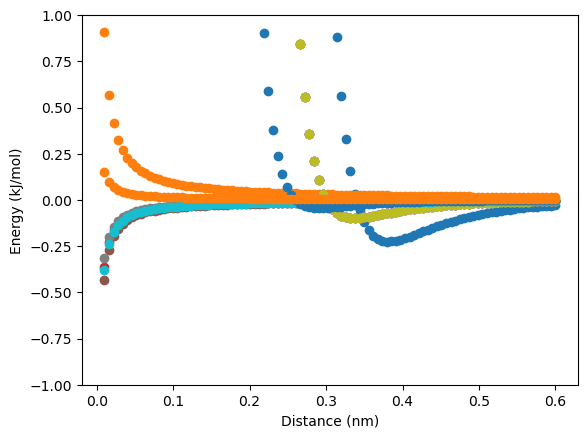

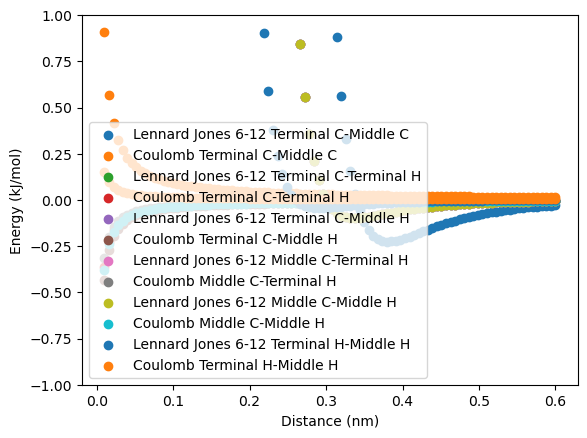

In [84]:
#Plot LJ and Couloumb Potentionals Here

coulomb14scale=0.833333
lj14scale=0.5

e_o=55.26349406 #ev/e/um
e_o*=10**-3 #ev/e/nm

my_dict={'Terminal C':{'charge':-0.0932, 'sigma':0.3397710, 'epsilon':0.4510352},
         'Middle C':{'charge':-0.0814, 'sigma':0.3397710, 'epsilon':0.4510352},
         'Terminal H':{'charge':0.0324, 'sigma':0.2600177, 'epsilon':0.0870272},
         'Middle H':{'charge':0.0387, 'sigma':0.2600177, 'epsilon':0.0870272}}

def combine_sig(sig1,sig2):
    return 0.5*sig1 + 0.5*sig2

def combine_ep(ep1,ep2):
    return (ep1*ep2)**0.5

def LJ(p1,p2,r):
    return lj14scale*4*combine_ep(p1['epsilon'],p2['epsilon'])*((combine_sig(p1['sigma'],p2['sigma'])/r)**12-(combine_sig(p1['sigma'],p2['sigma'])/r)**6)

def coulomb(p1,p2,r):
   return coulomb14scale/(4*np.pi*e_o)*p1['charge']*p2['charge']/r

for i in combinations(my_dict.keys(),2):
    dist=np.linspace(0.01,.6,100)
    plt.scatter(dist,[LJ(my_dict[i[0]],my_dict[i[1]],j) for j in dist],label=f'Lennard Jones 6-12 {i[0]}-{i[1]}')#,color='red')
    plt.scatter(dist,[coulomb(my_dict[i[0]],my_dict[i[1]],j) for j in dist],label=f'Coulomb {i[0]}-{i[1]}')#,color='blue')
plt.xlabel('Distance (nm)')
plt.ylabel('Energy (kJ/mol)')
plt.ylim([-1,1])
plt.show()

#show the same plot again but with an ugly legend that takes up most of plot area

for i in combinations(my_dict.keys(),2):
    dist=np.linspace(0.01,.6,100)
    plt.scatter(dist,[LJ(my_dict[i[0]],my_dict[i[1]],j) for j in dist],label=f'Lennard Jones 6-12 {i[0]}-{i[1]}')#,color='red')
    plt.scatter(dist,[coulomb(my_dict[i[0]],my_dict[i[1]],j) for j in dist],label=f'Coulomb {i[0]}-{i[1]}')#,color='blue')
plt.xlabel('Distance (nm)')
plt.ylabel('Energy (kJ/mol)')
plt.ylim([-1,1])
plt.legend()
plt.show()
